# Optimal Temperature for Maximal Rewards
- Finding the relationship between temperature and PMV
- Figure out how changing distribution of population affects performance (for POMDP env with energy) using vanilla DQN model.
    - PROBLEM: Energy is an overpowering reward factor. When user comfort is scaled to have a similar variance, agent does not converge.
- NEXT STEP: Trying to get POMDP to converge first
- Refer to hitl_only_tuning.ipynb

## Relationship between temperature and PMV

In [ ]:
from pythermalcomfort.models import pmv_ppd

In [ ]:
vr = 0.1 # m/s air speed
rh = 50 # relative humidity

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pythermalcomfort.models import pmv_ppd

class PMVCalculator:
    def __init__(self, vr, rh):
        self.vr = vr
        self.rh = rh
        self.map_functions()

    def map_functions(self):
        modes = []
        for met in [1.1, 1.2, 1.3]:
            for clo in [0.46, 0.57, 0.68]:
                modes.append({"met": met, "clo": clo})
        self.function_mapping = {i: mode for i, mode in enumerate(modes)}

    def pmv(self, mode, temp):
        length = len(mode)
        met, clo = [], []
        for m in mode:
            mapping = self.function_mapping[m]
            met.append(mapping['met'])
            clo.append(mapping['clo'])
        self.pmv_scores = pmv_ppd([temp]*length, 
                                  [temp]*length, 
                                  [self.vr]*length, 
                                  [self.rh]*length, 
                                  met, 
                                  clo, 
                                  standard="ASHRAE")['pmv'].reshape(-1)
        return self.pmv_scores

# Initialize PMVCalculator
vr = 0.1  # m/s air speed
rh = 50   # relative humidity
pmv_calculator = PMVCalculator(vr, rh)

# Temperature range
temps = np.arange(20, 28.5, 0.01)

# Calculate PMV values for each mode
pmv_values = {}
for mode in range(9):
    pmv_values[mode] = pmv_calculator.pmv([mode], temps)

# Plot PMV changes with met and clo changes
plt.figure(figsize=(14, 8))
for mode, pmv in pmv_values.items():
    met = pmv_calculator.function_mapping[mode]['met']
    clo = pmv_calculator.function_mapping[mode]['clo']
    plt.plot(temps, pmv, label=f"Met: {met}, Clo: {clo}")

plt.xlabel('Temperature (°C)')
plt.ylabel('PMV')
plt.title('PMV Changes with Met and Clo')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Calculate PMV values for each mode
pmv_values = {}
linear_fits = {}
for mode in range(9):
    pmv_values[mode] = pmv_calculator.pmv([mode], temps)
    
    # Perform linear regression
    X = temps.reshape(-1, 1)
    y = pmv_values[mode]
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    r2 = r2_score(y, y_pred)
    linear_fits[mode] = {'slope': reg.coef_[0], 'intercept': reg.intercept_, 'r2': r2, 'y_pred': y_pred}

# Plot PMV changes with met and clo changes
plt.figure(figsize=(14, 8))
for mode, pmv in pmv_values.items():
    met = pmv_calculator.function_mapping[mode]['met']
    clo = pmv_calculator.function_mapping[mode]['clo']
    plt.plot(temps, pmv, label=f"Met: {met}, Clo: {clo}")
    plt.plot(temps, linear_fits[mode]['y_pred'], linestyle='--', label=f"Linear Fit Met: {met}, Clo: {clo} (R²={linear_fits[mode]['r2']:.2f})")

plt.xlabel('Temperature (°C)')
plt.ylabel('PMV')
plt.title('PMV Changes with Met and Clo and Linear Fit')
plt.legend()
plt.grid(True)
plt.show()

# R^2 shows that there is a linear relationship between PMV and temperature

# Optimise reward using temperature

In [ ]:
# def predict_vote(self, mode, temp):
#     pmvs = self.pmv(mode, temp)
#     votes = np.where((pmvs >= -0.5) & (pmvs <= 0.5), 0, -1)
#     return votes

# For any value that has a magnitude larger than 0.5, we assign votes accordingly, -1 if has a magnitude > 0.5
# Larger PMV, the better

# def predict(self, temp, ambient_temp, alpha=1, beta=0.03):
#     q = -m * c_p * abs(temp - ambient_temp)
#     power = q / (TIME_INTERVAL / timedelta(hours=1)) / 1000
#     if len(self.agents) > 0:
#         df = self.get_group_data_df()
#         pred = self.model.predict_score(df['user'].values, temp)
#         # print('Predicted Comfort: ', pred)
#         # print('Power Consumed: ', power)
#         # print('Formula for Sum: ', alpha * VOLUME * pred.sum() / (len(df) ** 0.4) + beta * power)
#         # print('Formula for Mean: ', alpha * VOLUME * pred.mean() / (len(df) ** 0.4) + beta * power)
#         # print('='*20)
#         rl_reward, x = (alpha * VOLUME * pred.sum() / (len(df) ** 0.4) + beta * power), (alpha * VOLUME * pred.mean() / (len(df) ** 0.4) + beta * power)
#         return rl_reward, x
#     else:
#         print('No agents in group')
#         return power

# Weighted average PMV + weighted power




In [ ]:
import numpy as np
from scipy.optimize import minimize
from datetime import timedelta

class TemperatureOptimizer:
    def __init__(self, volume, alpha, beta, m, c_p, TIME_INTERVAL, agents, model):
        self.volume = volume
        self.alpha = alpha
        self.beta = beta
        self.m = m
        self.c_p = c_p
        self.TIME_INTERVAL = TIME_INTERVAL
        self.agents = agents
        self.model = model

    def predict_vote(self, mode, temp):
        pmvs = self.pmv(mode, temp)
        votes = np.where((pmvs >= -0.5) & (pmvs <= 0.5), 0, -1)
        return votes

    def pmv(self, mode, temp):
        # Dummy implementation for PMV calculation (replace with actual calculation)
        return np.random.randn(len(temp))

    def get_group_data_df(self):
        # Dummy implementation for group data (replace with actual data fetching)
        return np.random.randn(len(self.agents))

    def reward_function(self, temp, ambient_temp):
        q = -self.m * self.c_p * abs(temp - ambient_temp)
        power = q / (self.TIME_INTERVAL / timedelta(hours=1)) / 1000
        if len(self.agents) > 0:
            df = self.get_group_data_df()
            pred = self.model.predict_score(self.agents, temp) # Different modes
            rl_reward = self.alpha * self.volume * pred.sum() / (len(df) ** 0.4) + self.beta * power # Is negative, want to be as close to 0 as possible
            print(f'Temp: {temp}, Total:{rl_reward}, PMV_Reward: {self.alpha * self.volume * pred.sum() / (len(df) ** 0.4)}, Power_Reward:{self.beta * power}')

            return rl_reward
        else:
            return power

    def optimize_temperature(self, ambient_temp, initial_temp_guess=25.0):
        # Define the objective function to minimize (negative of reward function for maximization)
        def objective(temp):
            return -self.reward_function(temp, ambient_temp)
        
        # Perform the optimization
        result = minimize(objective, initial_temp_guess, bounds=[(ambient_temp-10, ambient_temp+10)])
        
        return result.x[0]

In [ ]:
from gym_examples.utils.thermal_comfort_model_sim import ThermalComfortModelSim

volume = 10  # example volume
alpha = 1
beta = 100000
m = 2  # mass of the system
c_p = 2  # specific heat capacity
TIME_INTERVAL = timedelta(hours=0.5)
agents = [1, 1, 1, 1, 1, 1, 1, 1, 1]  # dummy agent list
model = ThermalComfortModelSim()  # replace with actual model


optimizer = TemperatureOptimizer(volume, alpha, beta, m, c_p, TIME_INTERVAL, agents, model)
ambient_temp = 25  # example ambient temperature

In [ ]:
temps = [20+0.2*i for i in range(50)]

for i in range(len(temps)):
    reward = optimizer.reward_function(temps[i], ambient_temp)
    print("------------------------------------")
    print(f"Temperature: {temps[i]}, RL Reward: {reward}")

In [ ]:
optimal_temp = optimizer.optimize_temperature(ambient_temp)
max_reward = optimizer.reward_function(optimal_temp, ambient_temp)

print(f"\n\n Optimal Temperature: {optimal_temp}, Max RL Reward: {max_reward}")

In [ ]:
## Finding 1: Scale of power rewards and pmv rewards dramatically change based on parameters
    ## Therefore, it is important to continuously tune alpha and beta
    ## DONE: Figure out the most common ("fixed") variables for m_p etc
    ##      Then we switch temperatures 
    ##      All while checking the optimiser function is working


# Changing Distribution
Works only because the energy rewards is overpowering user comfort

In [1]:
## 
import torch 
import gymnasium as gym
import gym_examples

# set up matplotlib
from IPython import display

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

env = gym.make("AirconEnvironment-v0", is_render=False,  w_usercomfort=1, w_energy=1)
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

In [2]:
for i in range(10):
    observation, reward, terminated, truncated, _ = env.step(26)
    print("--------------")


28.6 25.2
Upvotes:0, Downvotes:0 Number of humans 3235
comfort score: 0 power score: -508.7556000000003
{'ambient_temp': array([28.6], dtype=float32), 'vote_up': array([0.], dtype=float32), 'vote_down': array([0.], dtype=float32), 'population_size': array([3235.], dtype=float32), 'curr_time_sec': array([37800.], dtype=float32), 'temp_setpt': array([25.2], dtype=float32)}
--------------
29.1 25.2
Upvotes:0, Downvotes:0 Number of humans 714
comfort score: 0 power score: -583.5726000000003
{'ambient_temp': array([29.1], dtype=float32), 'vote_up': array([0.], dtype=float32), 'vote_down': array([0.], dtype=float32), 'population_size': array([714.], dtype=float32), 'curr_time_sec': array([39600.], dtype=float32), 'temp_setpt': array([25.2], dtype=float32)}
--------------
29.9 25.2
Upvotes:0, Downvotes:0 Number of humans 1285
comfort score: 0 power score: -703.2797999999999
{'ambient_temp': array([29.9], dtype=float32), 'vote_up': array([0.], dtype=float32), 'vote_down': array([0.], dtype=flo

## Alpha and Beta with changing population

######------------------------------------Starting training...------------------------------------######
######------------------------------------Resetting environment...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######


Comfort score: -2594.4414577584034 Power score: -1256.9255999999998
{'ambient_temp': array([29.4], dtype=float32), 'temp_setpt': array([21.], dtype=float32), 'pmv_n3': array([14.], dtype=float32), 'pmv_n2': array([32.], dtype=float32), 'pmv_n1': array([45.], dtype=float32), 'pmv_0': array([4.], dtype=float32), 'pmv_p1': array([3.], dtype=float32), 'pmv_p2': array([1.], dtype=float32), 'pmv_p3': array([3.], dtype=float32), 'curr_time_sec': array([37800.], dtype=float32)}
tempsetpt:21.0, reward:-3851.3670577584035


Comfort score: 1490.9068274185922 Power score: -149.634
{'ambient_temp': array([29.6], dtype=float32), 'temp_setpt': array([28.6], dtype=float32), 'pmv_n3': array([1.], d

/Users/waishunlee/Documents/UROP/hitl_hvac/models/HITLDQNAgent.py:112: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:334.)
  next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values




Comfort score: 391.69023092703236 Power score: -852.9137999999999
{'ambient_temp': array([30.5], dtype=float32), 'temp_setpt': array([24.8], dtype=float32), 'pmv_n3': array([10.], dtype=float32), 'pmv_n2': array([21.], dtype=float32), 'pmv_n1': array([49.], dtype=float32), 'pmv_0': array([29.], dtype=float32), 'pmv_p1': array([0.], dtype=float32), 'pmv_p2': array([0.], dtype=float32), 'pmv_p3': array([2.], dtype=float32), 'curr_time_sec': array([45000.], dtype=float32)}
tempsetpt:24.8, reward:-461.22356907296756


Comfort score: -213.96290187954037 Power score: -1017.5112
{'ambient_temp': array([30.], dtype=float32), 'temp_setpt': array([23.2], dtype=float32), 'pmv_n3': array([8.], dtype=float32), 'pmv_n2': array([28.], dtype=float32), 'pmv_n1': array([38.], dtype=float32), 'pmv_0': array([15.], dtype=float32), 'pmv_p1': array([0.], dtype=float32), 'pmv_p2': array([1.], dtype=float32), 'pmv_p3': array([4.], dtype=float32), 'curr_time_sec': array([46800.], dtype=float32)}
tempsetpt:23

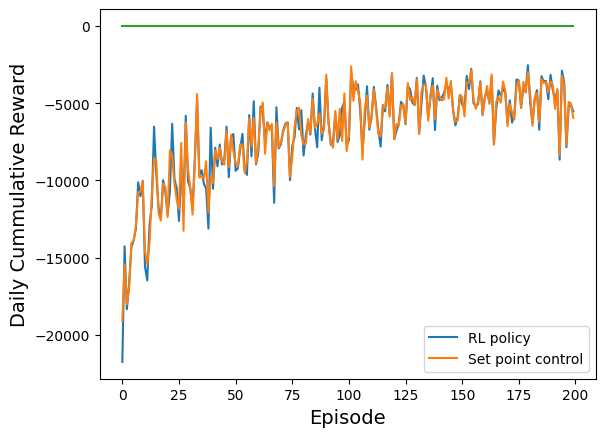

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Complete


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import torch
from gym_examples.utils.population import PopulationSimulation
from models.HITLDQNAgent import HITLDQNAgent

# Needed:Import gym environment (assumed to be already registered)
import gym_examples

LOAD_FILEPATH = "runs/saved_models/hitl_dqnv1"

def plot_durations(show_result=False):
    plt.figure(1)
    
    if not show_result:
        plt.clf()
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Daily Cummulative Reward', fontsize=14)
    plt.plot(rewards_ls, label="total")
    plt.plot(reward_power_ls, label="power")
    plt.plot(reward_user_comfort_ls, label="user_comfort")

    # plt.plot(fixed_rsts)
    plt.legend(["RL policy", "Set point control"])
    
    plt.pause(0.001)
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

if __name__ == "__main__":
    print("######------------------------------------Starting training...------------------------------------######")
    # set up matplotlib
    from IPython import display

    plt.ion()

    # if GPU is to be used
    device = torch.device(
        "cuda" if torch.cuda.is_available() else
        "mps" if torch.backends.mps.is_available() else
        "cpu"
    )

    population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 100, 20)
    # w_energy, w_usercomfort is from generated from a comfort score of range (-40 - 0) and power score (-1000 - -300)
    env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=100, w_energy=1)
    print("######------------------------------------Resetting environment...------------------------------------######")
    state, info = env.reset()
    n_observations = len(state)
    n_actions = env.action_space.n

    agent = HITLDQNAgent(n_observations, n_actions, device)

    episode_durations = []

    NUM_EPISODES = 200 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
    rewards_ls = []
    reward_user_comfort_ls = []
    reward_power_ls = []

    for i_episode in range(NUM_EPISODES):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        accum_rewards = 0
        accum_user_comfort_rewards = 0
        accum_power_rewards = 0
        done = False

        i = 0
        while not done:
            print("\n")
            action = agent.select_action(state)
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            accum_rewards += reward
            accum_user_comfort_rewards += info['w_comfort_score']
            accum_power_rewards += info['w_power_score']
            done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            agent.memorize(state, action, next_state, reward)
            state = next_state
            agent.optimize_model()

        rewards_ls.append(accum_rewards.item())
        reward_user_comfort_ls.append(accum_user_comfort_rewards)
        reward_power_ls.append(accum_power_rewards)

    agent.save_model(LOAD_FILEPATH)

    plot_durations(show_result=True)
    plt.ioff()
    plt.show()

    print('Complete')

In [2]:

TEST_EPISODES = 30

population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 100, 20)
# Evaluate against original population
env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=20, w_energy=1)
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

agent = HITLDQNAgent(n_observations, n_actions, device)
agent.set_learning(False) # No more random policy exploration

agent.load_model(LOAD_FILEPATH)


def evaluate_model(model, num_episodes=100):
    total_rewards = []
    total_comfort_rewards = []
    total_power_rewards = []
    
    for i_episode in range(TEST_EPISODES):
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        accum_rewards = 0
        accum_comfort_rewards = 0
        accum_power_rewards = 0
        done = False

        i = 0
        while not done:
            action = agent.select_action(state)
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            accum_rewards += reward
            accum_comfort_rewards += info['accum_user_comfort_rewards']
            accum_power_rewards += info['accum_power_rewards']
            done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            state = next_state

        total_rewards.append(accum_rewards.item())
        total_comfort_rewards.append(accum_comfort_rewards)
        total_power_rewards.append(accum_power_rewards)
    return total_rewards, total_comfort_rewards, total_comfort_rewards


#TODO: Update this for all models evaluated
hitl_energy_rewards, comfort_rewards, power_rewards = evaluate_model(agent, num_episodes=TEST_EPISODES)

plt.figure(figsize=(10, 5))
plt.plot(hitl_energy_rewards, label='hitl+energy')
plt.plot(comfort_rewards, label='comfort')
plt.plot(power_rewards, label='power')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

display.display(plt.gcf())

plt.ioff()
plt.show()

Comfort score: -302.51928985240784 Power score: -359.12160000000034
{'ambient_temp': array([29.8], dtype=float32), 'temp_setpt': array([27.4], dtype=float32), 'pmv_n3': array([2.], dtype=float32), 'pmv_n2': array([18.], dtype=float32), 'pmv_n1': array([47.], dtype=float32), 'pmv_0': array([40.], dtype=float32), 'pmv_p1': array([14.], dtype=float32), 'pmv_p2': array([0.], dtype=float32), 'pmv_p3': array([0.], dtype=float32), 'curr_time_sec': array([37800.], dtype=float32)}
tempsetpt:27.4, reward:-661.6408898524082


KeyError: 'accum_user_comfort_rewards'

Comfort score: -439.98287437314286 Power score: -179.56080000000043
{'ambient_temp': array([29.6], dtype=float32), 'temp_setpt': array([28.4], dtype=float32), 'pmv_n3': array([2.], dtype=float32), 'pmv_n2': array([43.], dtype=float32), 'pmv_n1': array([46.], dtype=float32), 'pmv_0': array([10.], dtype=float32), 'pmv_p1': array([3.], dtype=float32), 'pmv_p2': array([0.], dtype=float32), 'pmv_p3': array([0.], dtype=float32), 'curr_time_sec': array([37800.], dtype=float32)}
tempsetpt:28.4, reward:-619.5436743731433
Comfort score: -88.8652224820153 Power score: -209.48760000000033
{'ambient_temp': array([29.8], dtype=float32), 'temp_setpt': array([28.4], dtype=float32), 'pmv_n3': array([4.], dtype=float32), 'pmv_n2': array([60.], dtype=float32), 'pmv_n1': array([55.], dtype=float32), 'pmv_0': array([14.], dtype=float32), 'pmv_p1': array([0.], dtype=float32), 'pmv_p2': array([0.], dtype=float32), 'pmv_p3': array([0.], dtype=float32), 'curr_time_sec': array([39600.], dtype=float32)}
tempsetp

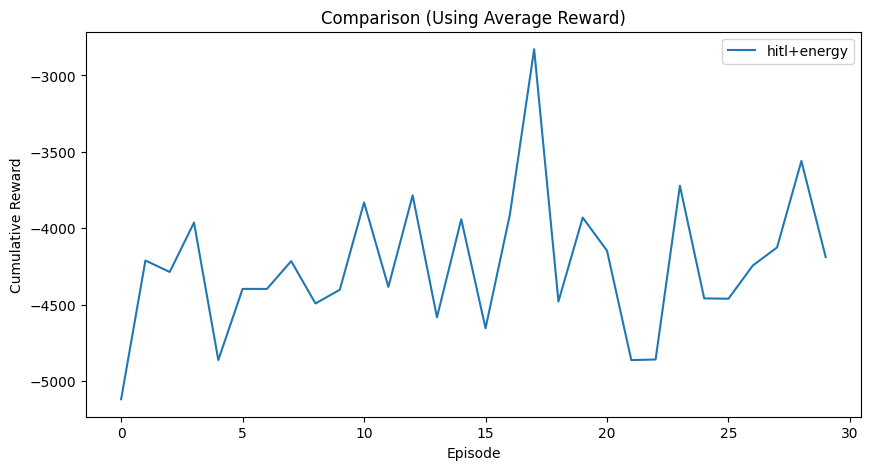

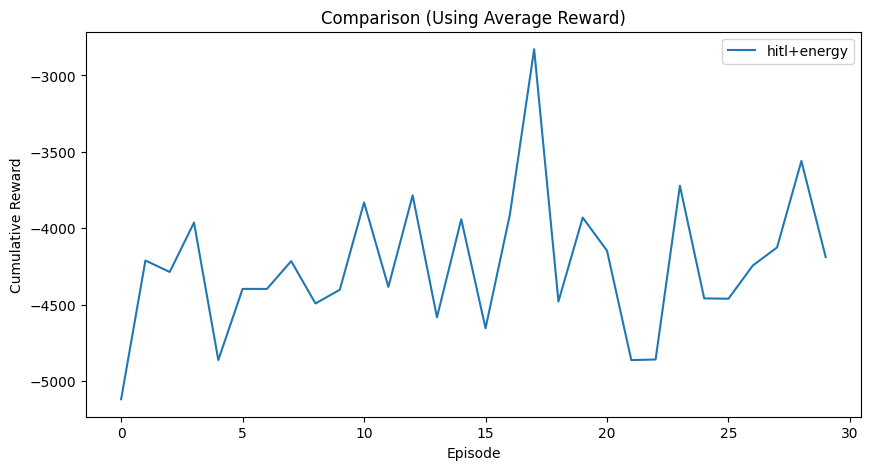

In [ ]:

TEST_EPISODES = 30
# Evaluate against new population (shift mean)
population_shift = PopulationSimulation(1.5, 1.05, 0.70, 0.25, 100, 20)

env = gym.make("AirconEnvironment-v0", population_simulation=population_shift, is_render=False, check_optimal=False ,w_usercomfort=20, w_energy=1)

#TODO: Update this for all models evaluated
hitl_energy_rewards, comfort_rewards, power_rewards = evaluate_model(agent, num_episodes=TEST_EPISODES)

plt.figure(figsize=(10, 5))
plt.plot(hitl_energy_rewards, label='hitl+energy')
plt.plot(comfort_rewards, label='comfort')
plt.plot(power_rewards, label='power')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

display.display(plt.gcf())

plt.ioff()
plt.show()

Comfort score: -558.2499886411766 Power score: -44.890199999999574
{'ambient_temp': array([28.1], dtype=float32), 'temp_setpt': array([28.4], dtype=float32), 'pmv_n3': array([0.], dtype=float32), 'pmv_n2': array([66.], dtype=float32), 'pmv_n1': array([63.], dtype=float32), 'pmv_0': array([0.], dtype=float32), 'pmv_p1': array([0.], dtype=float32), 'pmv_p2': array([0.], dtype=float32), 'pmv_p3': array([0.], dtype=float32), 'curr_time_sec': array([37800.], dtype=float32)}
tempsetpt:28.4, reward:-603.1401886411762
Comfort score: -97.01278265940275 Power score: -119.70720000000011
{'ambient_temp': array([29.2], dtype=float32), 'temp_setpt': array([28.4], dtype=float32), 'pmv_n3': array([0.], dtype=float32), 'pmv_n2': array([86.], dtype=float32), 'pmv_n1': array([83.], dtype=float32), 'pmv_0': array([0.], dtype=float32), 'pmv_p1': array([0.], dtype=float32), 'pmv_p2': array([0.], dtype=float32), 'pmv_p3': array([0.], dtype=float32), 'curr_time_sec': array([39600.], dtype=float32)}
tempsetpt:

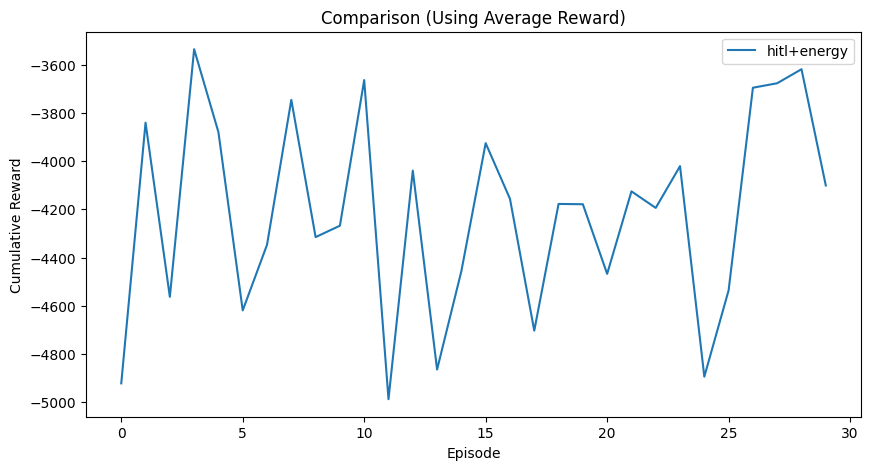

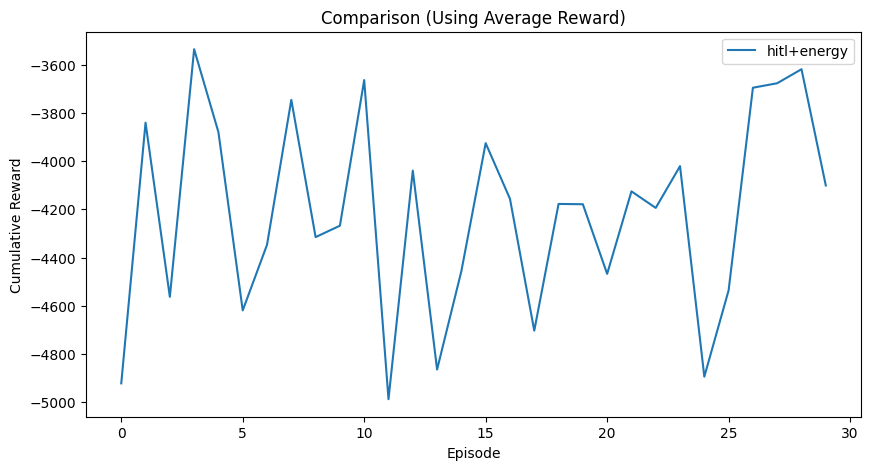

In [ ]:
TEST_EPISODES = 30
# Evaluate against new population
population_spread = PopulationSimulation(1.5, 0.3, 0.70, 0.05, 100, 20)
# population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 100, 20)
# metmu, metsigma, clomu, closigma, move_mu, move_sigma 
env = gym.make("AirconEnvironment-v0", population_simulation=population_spread, is_render=False, check_optimal=False ,w_usercomfort=20, w_energy=1)
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

agent = HITLDQNAgent(n_observations, n_actions, device)

#TODO: Update this for all models evaluated
hitl_energy_rewards, comfort_rewards, power_rewards = evaluate_model(agent, num_episodes=TEST_EPISODES)

plt.figure(figsize=(10, 5))
plt.plot(hitl_energy_rewards, label='hitl+energy')
plt.plot(comfort_rewards, label='comfort')
plt.plot(power_rewards, label='power')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

display.display(plt.gcf())

plt.ioff()
plt.show()

In [ ]:
TEST_EPISODES = 30
# Evaluate against new population
population_spread = PopulationSimulation(1.5, 0.3, 0.70, 0.05, 10000, 200)

env = gym.make("AirconEnvironment-v0", population_simulation=population_spread, is_render=False, check_optimal=False ,w_usercomfort=20, w_energy=1)
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

agent = HITLDQNAgent(n_observations, n_actions, device)

#TODO: Update this for all models evaluated
hitl_energy_rewards, comfort_rewards, power_rewards = evaluate_model(agent, num_episodes=TEST_EPISODES)

plt.figure(figsize=(10, 5))
plt.plot(hitl_energy_rewards, label='hitl+energy')
plt.plot(comfort_rewards, label='comfort')
plt.plot(power_rewards, label='power')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

display.display(plt.gcf())

plt.ioff()
plt.show()

Comfort score: -7255.668862467477 Power score: -59.85359999999979
{'ambient_temp': array([28.], dtype=float32), 'temp_setpt': array([28.4], dtype=float32), 'pmv_n3': array([0.], dtype=float32), 'pmv_n2': array([4653.], dtype=float32), 'pmv_n1': array([4838.], dtype=float32), 'pmv_0': array([0.], dtype=float32), 'pmv_p1': array([0.], dtype=float32), 'pmv_p2': array([0.], dtype=float32), 'pmv_p3': array([0.], dtype=float32), 'curr_time_sec': array([37800.], dtype=float32)}
tempsetpt:28.4, reward:-7315.5224624674765
Comfort score: -233.09038536032858 Power score: -0.0
{'ambient_temp': array([28.4], dtype=float32), 'temp_setpt': array([28.4], dtype=float32), 'pmv_n3': array([0.], dtype=float32), 'pmv_n2': array([4930.], dtype=float32), 'pmv_n1': array([5012.], dtype=float32), 'pmv_0': array([0.], dtype=float32), 'pmv_p1': array([0.], dtype=float32), 'pmv_p2': array([0.], dtype=float32), 'pmv_p3': array([0.], dtype=float32), 'curr_time_sec': array([39600.], dtype=float32)}
tempsetpt:28.4, r

KeyboardInterrupt: 